In [1]:
import pandas as pd 
import cv2, numpy as np
from scipy.stats import norm
import idx2numpy as idx
from copy import copy
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, precision_score, recall_score

# keras
np.random.seed(13)
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Reshape, Activation, SimpleRNN, GRU, LSTM, Convolution1D, \
                         MaxPooling1D, Merge, Dropout, Input
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
#from keras.utils.visualize_util import model_to_dot, plot
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras import backend as K
from keras.layers import Input, Flatten, Dense, Dropout, Activation, Lambda, Layer # keras.layers.core 
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.applications.vgg16 import VGG16
from keras import metrics

# logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using Theano backend.


In [2]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [3]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [4]:
batch_size = 100 # TODO 32 is standard; decrease futher for small datasets; has to be divisible by num training rows
original_dim = 784
latent_dim = 100 # TODO increase this but keep it below orig feature dim
intermediate_dim = 256
epochs = 5 # 50
epsilon_std = 1.0

### import data

In [5]:
(x_train_orig, y_train_0to9), (x_test_orig, y_test_0to9) = mnist.load_data()

In [6]:
print(x_train_orig.shape, y_train_0to9.shape, x_test_orig.shape, y_test_0to9.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


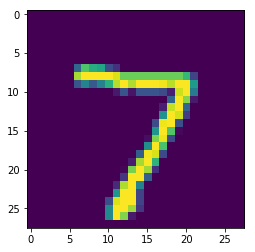

In [7]:
plt.figure()
plt.imshow(x_test_orig[0])
plt.show()

In [8]:
x_train = x_train_orig.astype('float32') / 255.
x_test = x_test_orig.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [9]:
print(x_train_orig.shape, x_train.shape, x_test_orig.shape, x_test.shape)

(60000, 28, 28) (60000, 784) (10000, 28, 28) (10000, 784)


In [10]:
# Preprocess class labels
y_train = np_utils.to_categorical(y_train_0to9, 10)
y_test = np_utils.to_categorical(y_test_0to9, 10)

In [11]:
print(y_test_0to9[0], "\n", y_test[0])

7 
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [12]:
print(y_train_0to9.shape, y_train.shape, y_test_0to9.shape, y_test.shape)

(60000,) (60000, 10) (10000,) (10000, 10)


### build vae

In [13]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [14]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [15]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [16]:
y = CustomVariationalLayer()([x, x_decoded_mean])

In [17]:
vae = Model(inputs=x, outputs=y)

In [18]:
vae.compile(optimizer='rmsprop', loss=None)

/home/katharina/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  if __name__ == '__main__':


### train vae

In [19]:
# train the VAE on MNIST digits
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 27s - loss: 165.6369 - val_loss: 141.9504
Epoch 2/5
60000/60000 [==============================] - 27s - loss: 136.8090 - val_loss: 129.6400
Epoch 3/5
60000/60000 [==============================] - 27s - loss: 126.6828 - val_loss: 122.0052
Epoch 4/5
60000/60000 [==============================] - 27s - loss: 119.7963 - val_loss: 116.3347
Epoch 5/5
60000/60000 [==============================] - 27s - loss: 115.7626 - val_loss: 113.5985


### get a separate model (the encoder) that outputs latent features

In [20]:
# build a model to project inputs on the latent space
encoder = Model(inputs=x, outputs=z_mean)

In [21]:
encoder_wt = encoder.get_weights()

In [22]:
print(encoder_wt[0].shape, encoder_wt[1].shape, encoder_wt[2].shape, encoder_wt[3].shape)

(784, 256) (256,) (256, 100) (100,)


In [23]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (100, 784)                0         
_________________________________________________________________
dense_1 (Dense)              (100, 256)                200960    
_________________________________________________________________
dense_2 (Dense)              (100, 100)                25700     
Total params: 226,660
Trainable params: 226,660
Non-trainable params: 0
_________________________________________________________________


In [24]:
encoder.layers

### explore encoder performance

In [25]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

In [26]:
print(x_test.shape, x_test_encoded.shape)

(10000, 784) (10000, 100)


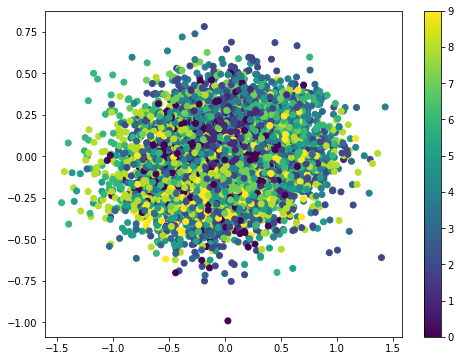

In [27]:
# the plot doesn't mean much with more than two latent features
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_0to9)
plt.colorbar()
plt.show()

### decoder stuff (not important for what I want to do)

In [ ]:
# # build a digit generator that can sample from the learned distribution
# decoder_input = Input(shape=(latent_dim,))
# _h_decoded = decoder_h(decoder_input)
# _x_decoded_mean = decoder_mean(_h_decoded)
# generator = Model(decoder_input, _x_decoded_mean)

In [ ]:
# # display a 2D manifold of the digits
# n = 15  # figure with 15x15 digits
# digit_size = 28
# figure = np.zeros((digit_size * n, digit_size * n))

In [ ]:
# # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# # to produce values of the latent variables z, since the prior of the latent space is Gaussian
# grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
# grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [ ]:
# for i, yi in enumerate(grid_x):
#     for j, xi in enumerate(grid_y):
#         z_sample = np.array([[xi, yi]])
#         x_decoded = generator.predict(z_sample)
#         digit = x_decoded[0].reshape(digit_size, digit_size)
#         figure[i * digit_size: (i + 1) * digit_size,
#                j * digit_size: (j + 1) * digit_size] = digit

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.imshow(figure, cmap='Greys_r')
# plt.show()

### pickle the encoder

In [ ]:
# TODO

### build classifier based on latent features

In [53]:
try:
    del clf
except:
    pass
finally:
    clf = Sequential()
    clf.add(encoder.layers[0])
    clf.add(encoder.layers[1])
    clf.add(encoder.layers[2])
    clf.set_weights(encoder_wt)
    
    for layer in clf.layers:
        layer.trainable = True # False
    
    clf.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, name='batchnorm'))
    clf.add(Dense(600, activation='relu', name='clf1'))
    clf.add(Dropout(0.5))
    clf.add(Dense(300, activation='relu', name='clf2'))
    n_classes = 10
    clf.add(Dense(n_classes, activation='softmax', name='predictions'))

In [54]:
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (100, 784)                0         
_________________________________________________________________
dense_1 (Dense)              (100, 256)                200960    
_________________________________________________________________
dense_2 (Dense)              (100, 100)                25700     
_________________________________________________________________
batchnorm (BatchNormalizatio (100, 100)                400       
_________________________________________________________________
clf1 (Dense)                 (100, 600)                60600     
_________________________________________________________________
dropout_5 (Dropout)          (100, 600)                0         
_________________________________________________________________
clf2 (Dense)                 (100, 300)                180300    
__________

In [55]:
# compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # TODO slowly lower lr to 0.01 or something else
clf.compile(optimizer=sgd, loss='categorical_crossentropy')

### train classifier

In [56]:
clf.fit(x_train, y_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s - loss: 0.2691 - val_loss: 0.1214
Epoch 2/5
60000/60000 [==============================] - 11s - loss: 0.1110 - val_loss: 0.1053
Epoch 3/5
 9400/60000 [===>..........................] - ETA: 9s - loss: 0.0861

KeyboardInterrupt: 

In [ ]:
# TODO  plot number of epochs (x axis) vs. accuracy (y axis)

### explore classifier performance

In [41]:
test_pred = clf.predict(x_test, batch_size=batch_size)

In [42]:
test_pred_0to9 = pd.Series(np.argmax(test_pred, 1), name = "pred")
y_test_0to9 = pd.Series(y_test_0to9, name = "true")

In [43]:
pd.crosstab(test_pred_0to9, y_test_0to9)

true,0,1,2,3,4,5,6,7,8,9
pred,,,,,,,,,,
0,970,0,7,0,1,3,5,2,5,4
1,0,1129,1,0,0,0,2,7,0,5
2,0,1,996,1,3,0,1,13,2,0
3,1,1,6,989,0,4,1,4,11,11
4,0,0,5,0,958,2,6,3,4,15
5,1,1,0,11,0,874,4,0,3,2
6,4,1,2,0,6,3,937,0,4,2
7,1,0,6,4,2,0,0,993,4,6
8,3,2,9,4,2,6,2,0,938,4


In [44]:
for avg in ["micro", "macro"]:
    accuracy = accuracy_score(y_test_0to9, test_pred_0to9)
    precision = precision_score(y_test_0to9, test_pred_0to9, average = avg)
    recall = recall_score(y_test_0to9, test_pred_0to9, average = avg)
    f1 = f1_score(y_test_0to9, test_pred_0to9, average = avg)
    print(avg, "average: accuracy", format(accuracy, "6.4f"), \
          "precision", format(precision, "6.4f"), \
          "recall", format(recall, "6.4f"), \
          "f1", format(f1, "6.4f"))

micro average: accuracy 0.9744 precision 0.9744 recall 0.9744 f1 0.9744
macro average: accuracy 0.9744 precision 0.9742 recall 0.9743 f1 0.9742


In [ ]:
weird_ones = y_test_0to9 != test_pred_0to9
pick_a_few = range(5)
for ind in pick_a_few:
    print("true", y_test_0to9[weird_ones][ind], "prediction", list(test_pred_0to9[weird_ones])[ind])
    plt.figure()
    plt.imshow(x_test_orig[weird_ones][ind])
    plt.show()